# <center> *Phase 1:* **Positional Boolean Search**

In [1]:
from hazm import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import string
import operator
import pickle
import time

In [2]:
class Word:
    def __init__(self, term):
        self.term = term
        self.freq = 0
        self.postings = {}

    def add_posting(self, doc_id, position):
        if doc_id in self.postings:
            self.postings[doc_id].append(position)
        else:
            self.postings[doc_id] = [position]

        self.freq += 1

In [3]:
class MainDictionary:
    def __init__(self):
        self.dictionary = {}
        self.documents_titles = []

    def add_word(self, term, doc_id, position):
        if term in self.dictionary:
            word = self.dictionary[term]
        else:
            word = Word(term)

        word.add_posting(doc_id, position)
        self.dictionary[term] = word

    def get_dict(self):
        return self.dictionary

    def set_doc_titles(self, doc_titles):
        self.documents_titles = doc_titles

    def get_docs(self, doc_ids):
        return [self.documents_titles[i] for i in doc_ids]

    def search_query(self, query):
        try:
            word = self.dictionary[query]
            return word.postings
        except KeyError:
            return {}

In [4]:
def read_documents():
    df = pd.read_excel("..\\Phase1\\IR1_7k_news.xlsx")
    contents = df['content'].tolist()
    titles = df['title'].tolist()
    return contents, titles

In [5]:
def refine_token(token):
    punc = ".،؛:؟!«»(){}[]" + string.punctuation
    refined_token = token.translate(str.maketrans('', '', punc))

    return refined_token

In [6]:
def preprocess(documents):
    normalizer = Normalizer(token_based=True)
    lemmatizer = Lemmatizer()
    documents_tokens = []

    count = 0
    for document in documents:
        normalized_doc = normalizer.normalize(document)

        tokens = word_tokenize(normalized_doc)
        final_tokens = []

        for token in tokens:
            token = lemmatizer.lemmatize(token)
            token = refine_token(token)

            if not token:
                continue
            if token in stopwords_list():
                continue

            final_tokens.append(token)

        documents_tokens.append(final_tokens)
        # print(count)
        count += 1

    return documents_tokens

In [7]:
def tokens_number(tokens_list):
    if type(tokens_list) == list:
        return sum(tokens_number(tokens) for tokens in tokens_list)
    else:
        return 1

In [8]:
def build_dictionary():
    documents, titles = read_documents()
    doc_tokens = preprocess(documents)
    # print("Number of Tokens: T = " + str(tokens_number(doc_tokens)))
    dictionary = positional_indexing(doc_tokens)
    dictionary.set_doc_titles(titles)
    return dictionary

In [9]:
def save_dictionary(main_dictionary):
    with open('..\\Phase1\\dictionary.pkl', 'wb') as output:
        pickle.dump(main_dictionary, output)

In [10]:
# main_dictionary = build_dictionary()
# save_dictionary(main_dictionary)

In [11]:
def load_dictionary():
    with open('..\\Phase1\\dictionary.pkl', 'rb') as input:
        return pickle.load(input)

In [12]:
def check_Zipf(dictionary):
    sorted_words = sorted(dictionary.values(), key=operator.attrgetter('freq'), reverse=True)

    log_rank = np.log10(np.linspace(1, len(sorted_words), len(sorted_words)))
    log_cf = np.log10(np.array([word.freq for word in sorted_words]))
    plt.plot(log_rank, log_cf, 'b')

    cf1 = sorted_words[0].freq
    log_i = np.log10(np.linspace(2, len(sorted_words), len(sorted_words) - 1))
    log_cfi = np.log10(cf1) - log_i
    plt.plot(log_i, log_cfi, 'r')

    plt.title("Checking Zipf's Law after removing stop words")
    plt.legend(["Actual Values", "Zipf's Law"])
    plt.xlabel("log10 rank")
    plt.ylabel("log10 cf")
    # plt.savefig("zipf_after_stopwords")
    plt.show()

In [13]:
def check_heaps():
    log_M_root = np.log10([7664, 10762, 13016, 18292])
    log_T_root = np.log10([84020, 165259, 248753, 369820])
    log_M_nonroot = np.log10([10274, 14516, 17570, 24998])
    log_T_nonroot = np.log10([78804, 155059, 233399, 347643])

    mainM_root = 49318
    mainT_root = 1639504
    mainM_nonroot = 66766
    mainT_nonroot = 1552919

    plt.plot(log_T_root, log_M_root, 'b')
    [b_root, log_k_root] = np.polyfit(log_T_root, log_M_root, 1)
    plt.plot(log_T_root, b_root * log_T_root + log_k_root, 'g')

    plt.plot(log_T_nonroot, log_M_nonroot, 'r')
    [b_nonroot, log_k_nonroot] = np.polyfit(log_T_nonroot, log_M_nonroot, 1)
    plt.plot(log_T_nonroot, b_nonroot * log_T_nonroot + log_k_nonroot, 'm')

    plt.title("Checking Heaps' Law before and after finding roots")
    plt.legend(
        ["Actual Values after finding roots", "Heaps' Law after finding roots",
         "Actual Values before finding roots", "Heaps' Law before finding roots"])
    plt.xlabel("log10 T")
    plt.ylabel("log10 M")
    # plt.savefig("heaps_law")
    # plt.show()

    log_mainT_root = np.log10(mainT_root)
    pred_log_mainM_root = log_k_root + b_root * log_mainT_root
    pred_mainM_root = np.power(10, pred_log_mainM_root)

    log_mainT_nonroot = np.log10(mainT_nonroot)
    pred_log_mainM_nonroot = log_k_nonroot + b_nonroot * log_mainT_nonroot
    pred_mainM_nonroot = np.power(10, pred_log_mainM_nonroot)

    k_root = np.power(10, log_k_root)
    k_nonroot = np.power(10, log_k_nonroot)

    print("Values for k and b in root-mode:")
    print("k = ", k_root)
    print("b = ", b_root)
    print("================================")
    print("Number of Tokens in root-mode : ", mainT_root)
    print("Predicted Size of Vocabulary in root-mode : ", pred_mainM_root)
    print("Actual Size of Dictionary in root-mode : ", mainM_root)
    print("=============================================================")
    print("Values for k and b in nonroot-mode:")
    print("k = ", k_nonroot)
    print("b = ", b_nonroot)
    print("================================")
    print("Number of Tokens in nonroot-mode : ", mainT_nonroot)
    print("Predicted Size of Vocabulary in nonroot-mode : ", pred_mainM_nonroot)
    print("Actual Size of Dictionary in nonroot-mode : ", mainM_nonroot)

In [14]:
main_dictionary = load_dictionary()
dictionary = main_dictionary.get_dict()

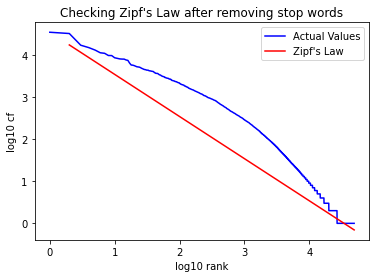

In [15]:
check_Zipf(dictionary)

Values for k and b in root-mode:
k =  11.787370095275488
b =  0.5689019785326529
Number of Tokens in root-mode :  1639504
Predicted Size of Vocabulary in root-mode :  40455.64649800604
Actual Size of Dictionary in root-mode :  49318
Values for k and b in nonroot-mode:
k =  14.463347478851963
b =  0.579873653187066
Number of Tokens in nonroot-mode :  1552919
Predicted Size of Vocabulary in nonroot-mode :  56279.845213439985
Actual Size of Dictionary in nonroot-mode :  66766


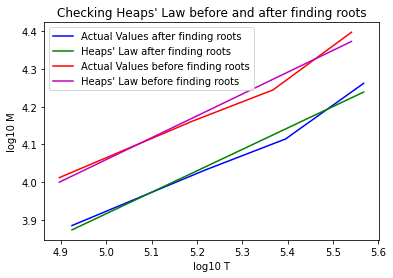

In [16]:
check_heaps()

In [17]:
def positional_intersect(p1, p2, k):
    doc_ids1 = list(p1.keys())
    doc_ids2 = list(p2.keys())
    doc_ids1.sort()
    doc_ids2.sort()

    answer = []
    i, j = 0, 0
    while i < len(doc_ids1) and j < len(doc_ids2):
        doc_id1 = doc_ids1[i]
        doc_id2 = doc_ids2[j]

        if doc_id1 == doc_id2:
            pp1 = p1[doc_id1]
            pp2 = p2[doc_id2]

            for pos in pp1:
                if pos + k in pp2 or pos - k in pp2:
                    answer.append(doc_id1)

            i, j = i + 1, j + 1
        elif doc_id1 < doc_id2:
            i += 1
        else:
            j += 1

    return answer

In [18]:
def search_phrase(phrase_dicts):
    results = []
    phrase_len = len(phrase_dicts)
    for i in range(phrase_len):
        for j in range(i + 1, phrase_len):
            distance = j - i
            results.append(positional_intersect(phrase_dicts[i], phrase_dicts[j], k=distance))
    try:
        return list(set.intersection(*map(set, results)))
    except TypeError:
        return results

In [19]:
def remove_duplicates(list):
    res_list = []
    for x in list:
        if x in res_list:
            continue
        res_list.append(x)
    return res_list

In [20]:
def query_permutations(query_dicts, num):
    permutations_list = []
    for i in range(len(query_dicts) - num + 1):
        permutations_list.append(query_dicts[i:i + num])
    return permutations_list

In [21]:
def boolean_search(query, dictionary, k=10):
    query_list = preprocess([query])[0]
    if len(query_list) == 1:
        answer_dict = dictionary.search_query(query_list[0])
        answer_keys = list(answer_dict.keys())
        answer_list = dictionary.get_docs(answer_keys)
    else:
        query_dicts = [dictionary.search_query(q) for q in query_list]
        answer_keys = []
        for l in reversed(range(len(query_dicts))):
            phrases = query_permutations(query_dicts, l + 1)
            for phrase in phrases:
                if len(phrase) > 1:
                    answer_keys += search_phrase(phrase)
                else:
                    answer_keys += list(phrase[0].keys())
        answer_list = dictionary.get_docs(remove_duplicates(answer_keys))

    return answer_list[:k]

In [22]:
while True:
    print(">> Please Enter your Query: ", end='')
    query = input()

    if not query:
        break

    start_time = time.time()
    print(">> Top 10 Results for «%s» : " % query)
    print("====================")
    for result in boolean_search(query, main_dictionary, k=10):
        print(result.strip())
    print("===================================================")
    print(">> Retrieval Time: --- %s seconds ---" % (time.time() - start_time))
    print("===================================================")

>> Please Enter your Query: تار ایرانی
>> Top 10 Results for «تار ایرانی» : 
موسیقی فولکلور مشهد در خانه ملک پیچید + ویدیو
وقتی نوای تار با دوتار خراسان آمیخته می‌شود + ویدیو
غافلگیری تار ایرانی در باغ شاهزاده ماهان
نوای «تار ایرانی» با دوتار خراسان درآمیخت + ویدیو
نقدی بر یادداشت «مرزبندی گفتمانی با طالبان»/ وارونه‌نمایی گفتمانی اصلاح‌طلبان
پیوست عدالت!
بیانیه بیش از هزار تن از چهره‌های حوزه علوم انسانی در حمایت از مردم افغانستان
نکاتی که باید در مورد واکسیناسیون کرونا بدانیم
نکاتی که باید در مورد واکسیناسیون کرونا بدانیم
نوایی در ستایش حسین علیزاده
>> Retrieval Time: --- 0.5853443145751953 seconds ---
>> Please Enter your Query: واکسن آسترازنکا
>> Top 10 Results for «واکسن آسترازنکا» : 
امکان ایجاد لخته خون در واکسن  آسترازنکا چقدر است؟
محموله ۱.۴ میلیون دوزی واکسن کرونا وارد کشور شد
نکاتی که باید در مورد واکسیناسیون کرونا بدانیم
محموله ۱.۴ میلیون دوزی واکسن کرونا وارد کشور شد
واکسن‌های کرونا با چه داروهایی تداخل دارند؟
واکسیناسیون؛عقلانی‌ترین راه مقابله با کرونا/پرهیز از تزریق واکسن